## Introduction
**Goal**: To classify whether tweets are from a real disaster or not. I will be using spacy and regex for the data preprocesing and then build an RNN using tensorflow keras.

**Data**: There are 3 files. Train.csv, test.csv, and sample_submission.csv. 
There are 7613 rows in the training data with 5 columns. These are

id - a unique identifier for each tweet

text - the text of the tweet

location - the location the tweet was sent from

keyword - a particular keyword from the tweet

target - contains values for whether disaster was real (1) or not (0)

The test data has 3263 rows without the target column. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload() #upload kaggle.json

#linux commands to create.kaggle folder current working directory and move kaggle.json file into folder
!pip install -q kaggle 
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 721kB/s]
100% 593k/593k [00:00<00:00, 721kB/s]


In [4]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 37.3 MB/s 
     |████████████████████████████████| 1.6 MB 56.3 MB/s 


In [6]:
# !pip install -q -U keras-tuner
import numpy as np 
import spacy
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout, GRU, Input
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import keras_tuner as kt
import regex as re
from collections import Counter
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
# !pip install bertopic[spacy] #for topic modeling with BERT
# !pip install -U spacy #required for data preporcessing 
# !pip install -U spacy[cuda113] #required if running on GPU  
# !pip install -U sentence-transformers #for transforming documents
# !pip install NLTK #for nlp preprocessing

nlp = spacy.load("en_core_web_sm")
from spacy.lang.en import English

In [61]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

In [39]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


### Data Preprocessing and EDA

In [40]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [42]:
train.duplicated().sum()

0

There are no duplicated tweets and no null values for the text, target, or id so we can con

In [43]:
tweet_lengths = [len(tweet) for tweet in train['text']]

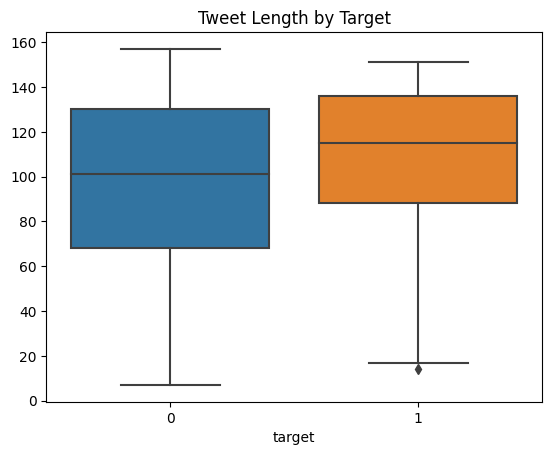

In [44]:
sns.boxplot(x = train['target'],y = tweet_lengths).set_title("Tweet Length by Target")
plt.show()

In [45]:
class Preprocessor:
  def __init__(self,df):
    self.df = df
    self.cleaner_tweets =  [self.cleaner(tweet) for tweet in self.df['text']]
    self.lem_tweets = [self.cleaning(doc) for doc in nlp.pipe(self.cleaner_tweets, batch_size=100)] 
    self.all_words = list(map(lambda tweet: tweet.split(), self.lem_tweets))
  def cleaner(self,tweet): #function for removing punctuation, url links, and more
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE) #removing all url links
    tweet = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", tweet)
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$s", " ", tweet)
    tweet = re.sub(r",", " , ", tweet)
    tweet = re.sub(r"!", "", tweet)
    tweet = re.sub(r"\(", " ", tweet)
    tweet = re.sub(r"\)", " ", tweet)
    tweet = re.sub(r"\?", "", tweet)
    tweet = re.sub(r"\{", " ", tweet)
    tweet = re.sub(r"\}", " ", tweet)
    tweet = re.sub(r"\[", " ", tweet)
    tweet = re.sub(r"\]", " ", tweet)
    tweet = re.sub(r"\-", "", tweet)
    tweet = re.sub(r"\_", " ", tweet)
    tweet = re.sub(r"\s{2,}", " ", tweet)
    tweet = re.sub(r"[\/,\@,\#,\?,\\,\{,\},\(,\),\[,\],\$,\%,\^,\&,\*,\<,\>]", "", tweet)
    tweet = re.sub(r'\([^)]*\)', '', tweet)
    tweet = re.sub('"','', tweet)
    tweet = re.sub(r"'s\b","",tweet)
    tweet = re.sub(r"\s+"," ",tweet)
    tweet = re.sub("[^a-zA-Z0-9]", " ", tweet)
    tweet = re.sub(r"\b\d+\b", "", tweet)
    tweet = tweet.strip().lower()
    return tweet
  def cleaning(self,doc):
    # Lemmatizes and removes stopwords, doc needs to be a spacy 'doc'
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)


In [46]:
df=pd.concat([train,test])
processed_df = Preprocessor(df)


In [47]:
processed_df.df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


Overall the tweets are very short so basic preprocessing will be enoguh for our purposes.

As can be seen above, spacy contains a tokenizer, tagger, parser, lemmatizer, and named entity recognition already built in. Spacy is preferable over NLP libraries such as NLTK due its processing speed and is the preferred NLP library in industry. 

We are speed up preprocessing process through nlp.pipe

In [18]:
def graph_frequency(df, all_tweets, num_words,target_num):
  target_string = "Disaster" if target_num == 1 else "Non-Disaster"
  style = "dark_background" if target_num == 1 else "default"
  indexes = list(df[df['target'] ==target_num].index.values)
  all_words = list(map(lambda tweet: tweet.split(), [all_tweets[i] for i in indexes]))
  all_words_flat =[word for tweet in all_words for word in tweet if word not in ['t','m','s']]
  freq_all_common = Counter(all_words_flat).most_common(num_words)
  plt.style.use(style)
  plt.figure(figsize=(min(int(num_words*.8),24), 5))
  sns.barplot(x=[word[0] for word in freq_all_common], y=[count[1] for count in freq_all_common])
  plt.title(f'Most Frequent Words in {target_string} Tweets')
  plt.show()


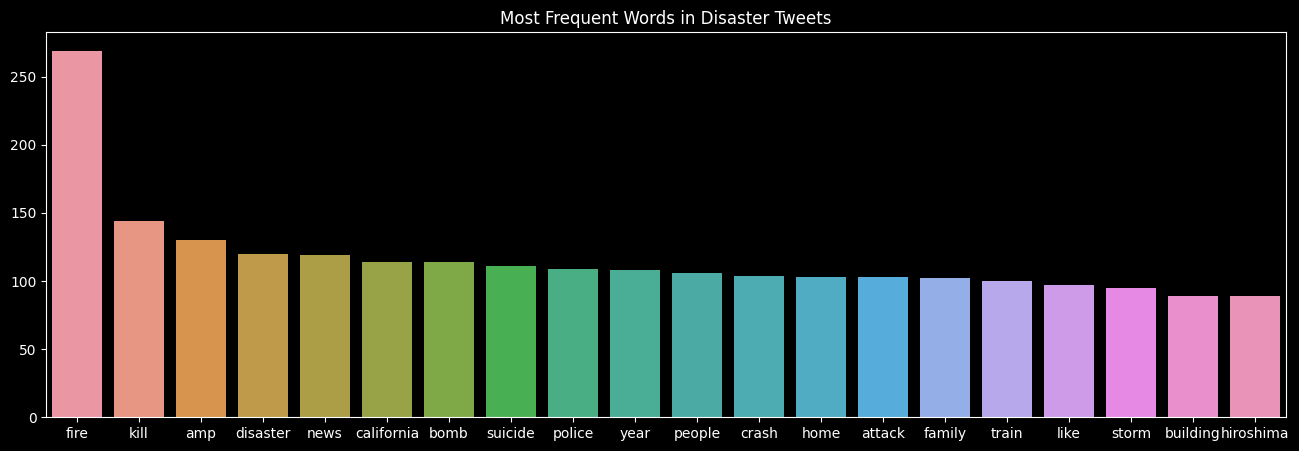

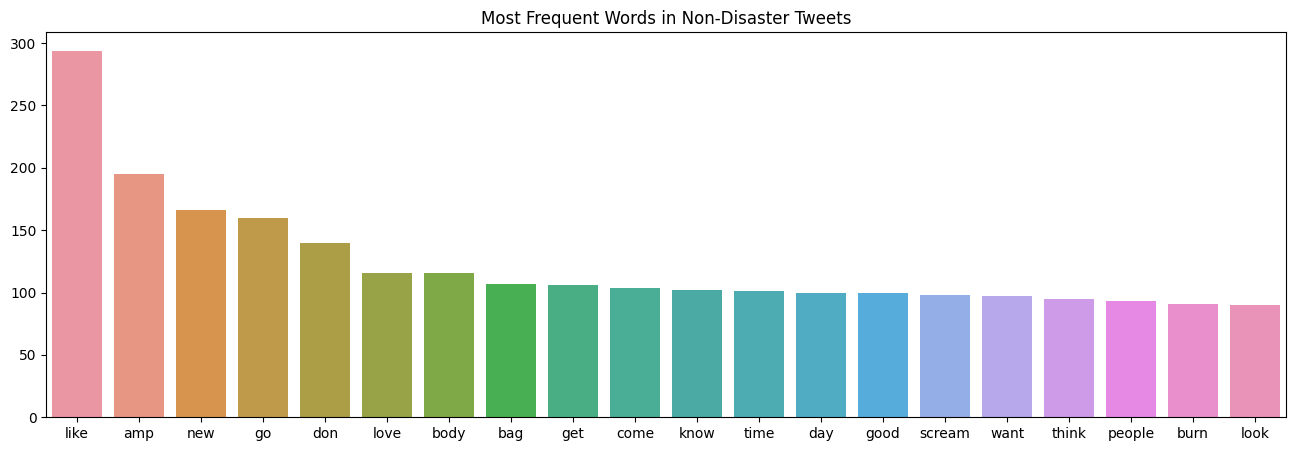

In [48]:
graph_frequency(processed_df.df,processed_df.lem_tweets,20,1)
graph_frequency(processed_df.df,processed_df.lem_tweets,20,0)

There are three main take aways form the graphs above:

1.   Tweets with actual disasters have common words that are longer than tweets not for natural disasters
2.   Tweets with actual disasters have much more violent words such as kill, suicide, attack, disaster, and fire
3. We need to look into what "amp" stands for since it is the second most common word in both graphs


### Vectorize with Glove
We will be using Glove as our vectorizer. I downliaded a pretrained word vectors for twitter from https://nlp.stanford.edu/projects/glove/ to speed up the modeling process and also improve the models performance. I used the 50-dimensional 

In [20]:
dict_glove={}
with open('/content/drive/MyDrive/glove.twitter.27B.50d.txt','r') as f: #reading file into dictioinary
    for line in f:
        vals=line.split()
        word=vals[0]
        vects=np.asarray(vals[1:],'float32')
        dict_glove[word]=vects
f.close()

In [54]:
def create_embeddings(processed_data):
  lengths = [len(processed_data.all_words[i]) for i in range(len(processed_data.all_words))] #getting lengths of every sequence
  print(f"The max length is {max(lengths)}, so we will set the max length for padding to this value") #we will pad to 22
  MAX_LENGTH= 22
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(processed_data.all_words) #fitting tokenizer on processed training data
  sequences=tokenizer.texts_to_sequences(processed_data.all_words) #creating sequences words
  tweet_pad=pad_sequences(sequences, maxlen=MAX_LENGTH,truncating='post',padding='post') #padding and truncting to make input lengths even for model
  word_dict =tokenizer.word_index
  num_unigrams = len(word_dict) + 1 #number of unique words (unigrams)
  embedding_matrix=np.zeros((num_unigrams,50)) #initializing embedding dictionary to store embedded values
  for word, i in word_dict.items():  
      if i < len(word_dict)+1: 
        glove_vec=dict_glove.get(word) #setting this iteratin of vectorizer
        if glove_vec is not None:
          embedding_matrix[i]= glove_vec #adding vectorized word to embedded matrix
  return embedding_matrix, tweet_pad

In [55]:
embeddings, tweet_padded = create_embeddings(processed_df)

The max length is 22, so we will set the max length for padding to this value


In [56]:
embeddings.shape

(17192, 50)

We will be builidng an LSTM (Long Short-Term Memory) neural network instead of standard Recurrent Neural Network since standard RNNs deal with the vanishing gradient problem by having more useful features such as a filter for predictions, forget gate, and more. LTSM also has the ability to look back more timesteps. In general, RNN or RNN varities tend to work vary well with sequntial patterns. 

**Model 1: LTSM Without Tuning**

In [57]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) #for early stopping


model=Sequential()


# Args:
# input_dim (Size of the vocabulary), output_dim ( Dimension of the dense embedding), embeddings_initializer (Initializer for the `embeddings`)
# input_length (Length of input sequences)
embedding=Embedding(len(embeddings),50,embeddings_initializer=Constant(embeddings),
                  input_length= 22 ,trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.2)) 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=5e-5)  

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 22, 50)            859600    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 22, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 889,105
Trainable params: 29,505
Non-trainable params: 859,600
_________________________________________________________________


In [60]:
train_df=tweet_padded[:train.shape[0]]
test_sub=tweet_padded[train.shape[0]:]

In [62]:
X_train,X_test,y_train,y_test=train_test_split(train_df,train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 22)
Shape of Validation  (1142, 22)


In [66]:
history=model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2, callbacks=[callback]) #smaller batch sizes peform better

Epoch 1/30
203/203 - 21s - loss: 0.5215 - accuracy: 0.7568 - val_loss: 0.5049 - val_accuracy: 0.7758 - 21s/epoch - 104ms/step
Epoch 2/30
203/203 - 19s - loss: 0.5033 - accuracy: 0.7719 - val_loss: 0.4963 - val_accuracy: 0.7793 - 19s/epoch - 92ms/step
Epoch 3/30
203/203 - 16s - loss: 0.4941 - accuracy: 0.7750 - val_loss: 0.4895 - val_accuracy: 0.7881 - 16s/epoch - 79ms/step
Epoch 4/30
203/203 - 17s - loss: 0.4919 - accuracy: 0.7707 - val_loss: 0.4832 - val_accuracy: 0.7907 - 17s/epoch - 82ms/step
Epoch 5/30
203/203 - 20s - loss: 0.4884 - accuracy: 0.7759 - val_loss: 0.4804 - val_accuracy: 0.7890 - 20s/epoch - 99ms/step
Epoch 6/30
203/203 - 26s - loss: 0.4913 - accuracy: 0.7735 - val_loss: 0.4777 - val_accuracy: 0.7881 - 26s/epoch - 130ms/step
Epoch 7/30
203/203 - 23s - loss: 0.4818 - accuracy: 0.7810 - val_loss: 0.4779 - val_accuracy: 0.7872 - 23s/epoch - 114ms/step
Epoch 8/30
203/203 - 16s - loss: 0.4850 - accuracy: 0.7772 - val_loss: 0.4754 - val_accuracy: 0.7872 - 16s/epoch - 80ms/st

In [69]:
from keras.saving.hdf5_format import load_model_from_hdf5
# !mkdir -p drive/MyDrive/Disaster_Tweet_Models
model.save('drive/MyDrive/Disaster_Tweet_Models/LSTMUntunedDec4.h5')
# model = load_model_from_hdf5('drive/MyDrive/Disaster_Tweet_Models/LSTMUntunedDec4.h5')

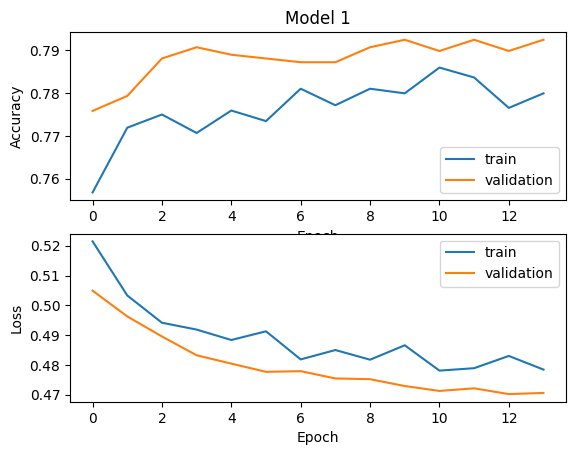

In [70]:
def plot_model_results(model_history, plot_title):
  fig, (ax1,ax2) = plt.subplots(2,1)
  ax1.plot(model_history.history['accuracy'])
  ax1.plot(model_history.history['val_accuracy'])
  ax1.set_title(plot_title)
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['train', 'validation'])

  ax2.plot(model_history.history['loss'])
  ax2.plot(model_history.history['val_loss'])
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend(['train', 'validation'])

  plt.show()
plot_model_results(history, "Model 1")

**Model 2: LTSM With tuning**

In [140]:
def build_model(hp):
    model2 = Sequential()
    model2.add(embedding)
    for i in range(hp.Int('n_layers', 1, 3)):
        model2.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model2.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model2.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model2.add(Dense(y_train.shape[0], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(0.2)) 
    model2.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2)) 
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model2

In [141]:
tuner= kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1
        )

In [142]:
tuner.search(
        x=X_train,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_test,y_test),
)

In [143]:
tuner

In [144]:
best_model = tuner.get_best_models(num_models=1)[0]

# best_model = load_model_from_hdf5('drive/MyDrive/Disaster_Tweet_Models/LTSM_Tuned.h5')

In [146]:
history2=best_model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2, callbacks=[callback])

Epoch 1/30
203/203 - 2s - loss: 0.2463 - mse: 0.2463 - val_loss: 0.2471 - val_mse: 0.2471 - 2s/epoch - 9ms/step
Epoch 2/30
203/203 - 2s - loss: 0.2465 - mse: 0.2465 - val_loss: 0.2484 - val_mse: 0.2484 - 2s/epoch - 8ms/step
Epoch 3/30
203/203 - 2s - loss: 0.2460 - mse: 0.2460 - val_loss: 0.2463 - val_mse: 0.2463 - 2s/epoch - 8ms/step
Epoch 4/30
203/203 - 2s - loss: 0.2460 - mse: 0.2460 - val_loss: 0.2451 - val_mse: 0.2451 - 2s/epoch - 8ms/step
Epoch 5/30
203/203 - 2s - loss: 0.2458 - mse: 0.2458 - val_loss: 0.2449 - val_mse: 0.2449 - 2s/epoch - 8ms/step
Epoch 6/30
203/203 - 2s - loss: 0.2453 - mse: 0.2453 - val_loss: 0.2451 - val_mse: 0.2451 - 2s/epoch - 8ms/step
Epoch 7/30
203/203 - 2s - loss: 0.2248 - mse: 0.2248 - val_loss: 0.2004 - val_mse: 0.2004 - 2s/epoch - 8ms/step
Epoch 8/30
203/203 - 2s - loss: 0.1669 - mse: 0.1669 - val_loss: 0.1672 - val_mse: 0.1672 - 2s/epoch - 9ms/step
Epoch 9/30
203/203 - 2s - loss: 0.1409 - mse: 0.1409 - val_loss: 0.1532 - val_mse: 0.1532 - 2s/epoch - 1

KeyError: ignored

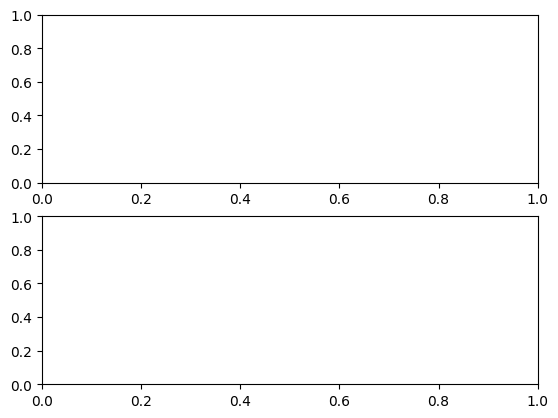

In [76]:
plot_model_results(history2, "Model 2")

In [147]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 22, 50)            859600    
                                                                 
 lstm (LSTM)                 (None, 22, 416)           777088    
                                                                 
 lstm_1 (LSTM)               (None, 22, 32)            57472     
                                                                 
 lstm_2 (LSTM)               (None, 256)               295936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 6471)              1663047   
                                                                 
 dense_1 (Dense)             (None, 128)               8

In [148]:
best_model.save('drive/MyDrive/Disaster_Tweet_Models/LTSM_Tuned.h5')

**Model 3: GRU without tuning**

In [88]:
model3 = Sequential()
model3.add(embedding)
model3.add(GRU(32))
model3.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=5e-5) #played around with different learning rates to determine optimal one 
model3.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [89]:
history3 =model3.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2, callbacks=[callback]) #smaller batch sizes peform better

Epoch 1/30
203/203 - 3s - loss: 0.6912 - accuracy: 0.5698 - val_loss: 0.6893 - val_accuracy: 0.5718 - 3s/epoch - 13ms/step
Epoch 2/30
203/203 - 1s - loss: 0.6876 - accuracy: 0.5702 - val_loss: 0.6857 - val_accuracy: 0.5718 - 925ms/epoch - 5ms/step
Epoch 3/30
203/203 - 1s - loss: 0.6842 - accuracy: 0.5704 - val_loss: 0.6825 - val_accuracy: 0.5718 - 894ms/epoch - 4ms/step
Epoch 4/30
203/203 - 1s - loss: 0.6799 - accuracy: 0.5707 - val_loss: 0.6753 - val_accuracy: 0.5718 - 800ms/epoch - 4ms/step
Epoch 5/30
203/203 - 1s - loss: 0.6462 - accuracy: 0.5936 - val_loss: 0.5915 - val_accuracy: 0.6839 - 850ms/epoch - 4ms/step
Epoch 6/30
203/203 - 1s - loss: 0.5551 - accuracy: 0.7447 - val_loss: 0.5394 - val_accuracy: 0.7364 - 806ms/epoch - 4ms/step
Epoch 7/30
203/203 - 1s - loss: 0.5180 - accuracy: 0.7605 - val_loss: 0.5198 - val_accuracy: 0.7531 - 850ms/epoch - 4ms/step
Epoch 8/30
203/203 - 1s - loss: 0.4968 - accuracy: 0.7708 - val_loss: 0.5067 - val_accuracy: 0.7680 - 795ms/epoch - 4ms/step
Ep

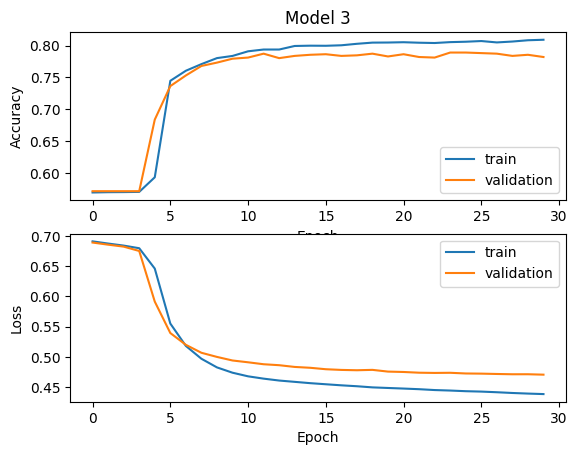

In [90]:
plot_model_results(history3, "Model 3")

In [91]:
model3.save('drive/MyDrive/Disaster_Tweet_Models/GRU_Untuned.h5')
# model3 = load_model_from_hdf5('drive/MyDrive/Disaster_Tweet_Models/GRU_Untuned.h5')

We should defintely perform hyperparameter tuning with out model. 

1.   List item
2.   List item



# Metrics

In [65]:
y_pred=model.predict(test_sub)
y_pred=np.round(y_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission_disaster1.csv',index=False)

102/102 [==============================] - 1s 9ms/step


In [151]:
y_pred2=best_model.predict(test_sub)
y_pred2=np.round(y_pred2).astype(int).reshape(3263)
sub=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_pred2})
sub.to_csv('submission_disaster2.csv',index=False)

102/102 [==============================] - 0s 4ms/step


In [153]:
y_pred3=model3.predict(test_sub)
y_pred3=np.round(y_pred3).astype(int).reshape(3263)
sub=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_pred3})
sub.to_csv('submission_disaster3.csv',index=False)

102/102 [==============================] - 0s 2ms/step


### Metrics/ Conclusion

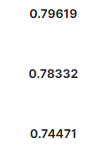

These are the accuracy scores for models 3,2, and 1 respectively. They hyperparameter tuning appeared to improve model performance and the Gated Recurrent Network unit model surprisingly outperformed the other two models. I had read that LTSM generally outperformed GRU but the hyperparameter tuning done was very basic wihtout much account for how I implmeneted it. It goes to show that more shallow and simplistic models often times outperform more complex ones. 

Note: I ran into some issues with separating the train and test data when building the corpus but will resolve that at a later date. There were indexing issues when trying to add the inputs of the test model into my 3 models. I understand that the model will generalize more poorly on new data since I combined the data that was supposed to be new data into my preprocessing and formation of glove.

References: 




* https://medium.com/analytics-vidhya/hypertuning-a-lstm-with-keras-tuner-to-forecast-solar-irradiance-7da7577e96eb
*   https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove



